Total samples: 5592
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
✅ Scaler dan label encoder berhasil dimuat
✅ X shape after reshape for CNN: (5592, 225, 1)
✅ y shape: (5592, 26)
Train size: 4473, Test size: 1119
✅ Model huruf CNN berhasil dimuat
35/35 [==============================] - 1s 9ms/step - loss: 2.9227 - accuracy: 0.1475

Test Loss: 2.9227
Test Accuracy: 0.1475
35/35 [==============================] - 0s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        46
           B       0.00      0.00      0.00        46
           C       0.00      0.00      0.00        46
           D       0.05      0.87      0.09        47
           E       0.50      0.11      0.18        47
           F       0.44      0.09      0.15        46
           G       0.53      0.21      0.30        47
           H       0.

/opt/anaconda3/envs/slenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/slenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/slenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

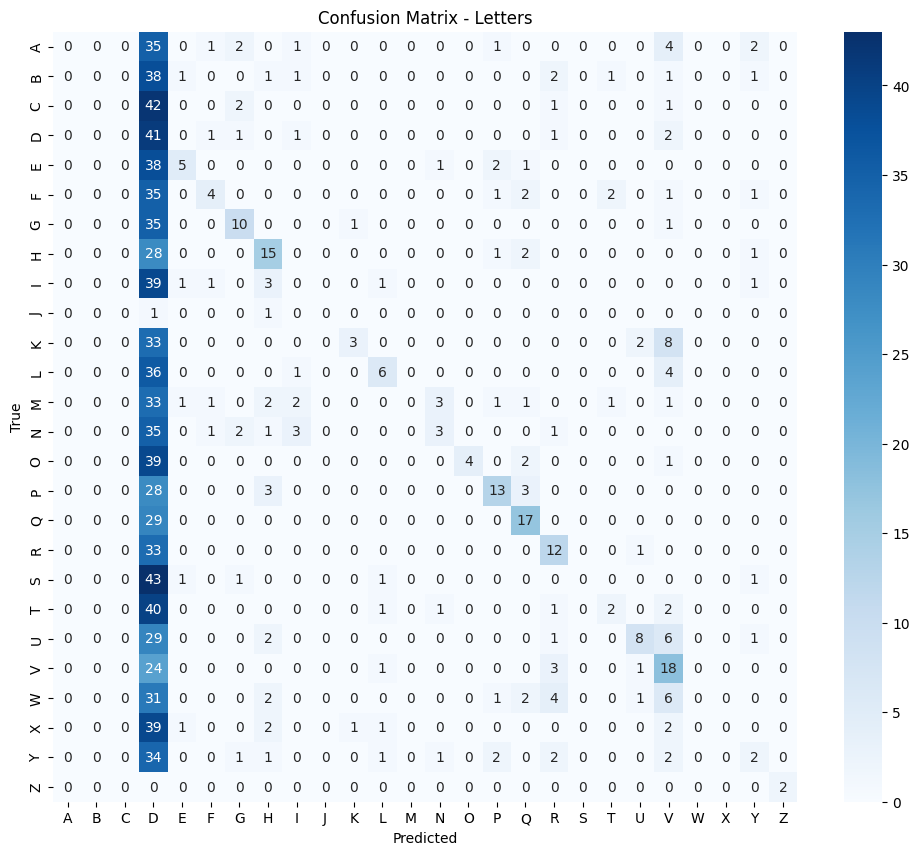

1/1 [==============================] - 0s 35ms/step

🔍 Sample Test:
True Label: B
Predicted Label: H


In [3]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import pickle

# ====== 1️⃣ Load dataset processed ======
data_dir = "../../dataset/processed_letters"
classes = sorted(os.listdir(data_dir))

X, y = [], []

for label_idx, label_name in enumerate(classes):
    class_dir = os.path.join(data_dir, label_name)
    for file in os.listdir(class_dir):
        if file.endswith(".npy"):
            path = os.path.join(class_dir, file)
            features = np.load(path, allow_pickle=True)
            X.append(features)
            y.append(label_idx)

print(f"Total samples: {len(X)}")
print(f"Classes: {classes}")

# ====== 2️⃣ Load scaler & label encoder ======
scaler_path = "../../models/scaler_letter.pkl"
label_path = "../../models/label_letter_encoder.pkl"

if os.path.exists(scaler_path) and os.path.exists(label_path):
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    with open(label_path, "rb") as f:
        le = pickle.load(f)
    print("✅ Scaler dan label encoder berhasil dimuat")
else:
    scaler = MinMaxScaler()
    X_np = np.array(X)
    scaler.fit(X_np)
    print("⚠️ Scaler baru dibuat (MinMax 0-1)")

# ====== 3️⃣ Preprocessing ======
X = np.array(X, dtype='float32')
X_scaled = scaler.transform(X)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
y_cat = to_categorical(y)

print(f"✅ X shape after reshape for CNN: {X_cnn.shape}")
print(f"✅ y shape: {y_cat.shape}")

# ====== Split data ======
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cat, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ====== Load / Build 1D-CNN model ======
model_path = "../../models/sign_letter_model.keras"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("✅ Model huruf CNN berhasil dimuat")
else:
    input_shape = X_train.shape[1:]
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32)
    model.save(model_path)
    print("✅ Model 1D-CNN baru dibuat dan disimpan")

# ====== Evaluasi ======
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# ====== Confusion Matrix ======
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Letters')
plt.show()

# ====== Cek sample acak ======
idx = np.random.randint(0, len(X_test))
sample = X_test[idx:idx+1]
true_label = classes[np.argmax(y_test[idx])]
pred_label = classes[np.argmax(model.predict(sample))]

print(f"\n🔍 Sample Test:")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
